In [1]:
import os
import sys
import argparse
import torch
from getdist import plots, MCSamples
import getdist
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

In [2]:
path = os.path.realpath(os.path.join(os.getcwd(), '../..'))
sys.path.insert(0, path)

In [3]:
from nnest import MCMCSampler

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [5]:
# Himmelblau
dims = 2
def loglike(z):
    z1 = z[:, 0]
    z2 = z[:, 1]
    return - (z1**2 + z2 - 11.)**2 - (z1 + z2**2 - 7.)**2

In [6]:
# Rosenbrock
#dims = 4
#def loglike(z):
#    return np.array([-sum(100.0 * (x[1:] - x[:-1] ** 2.0) ** 2.0 + (1 - x[:-1]) ** 2.0) for x in z])

In [7]:
# Gauss
#corr = 0.99
#dims = 2
#def loglike(x):
#    return multivariate_normal.logpdf(x, mean=np.zeros(dims), cov=np.eye(dims) + corr * (1 - np.eye(dims)))

In [8]:
sampler = MCMCSampler(dims, loglike, hidden_dim=64, num_layers=1, num_blocks=5, scale='constant', flow='spline')

Creating directory for new run logs/test/run40
[nnest.trainer] [INFO] SingleSpeedSpline(
  (flow): NormalizingFlow(
    (flows): ModuleList(
      (0): ActNorm()
      (1): Invertible1x1Conv()
      (2): NSF_CL(
        (f1): MLP(
          (net): Sequential(
            (0): Linear(in_features=1, out_features=16, bias=True)
            (1): LeakyReLU(negative_slope=0.2)
            (2): Linear(in_features=16, out_features=16, bias=True)
            (3): LeakyReLU(negative_slope=0.2)
            (4): Linear(in_features=16, out_features=16, bias=True)
            (5): LeakyReLU(negative_slope=0.2)
            (6): Linear(in_features=16, out_features=23, bias=True)
          )
        )
        (f2): MLP(
          (net): Sequential(
            (0): Linear(in_features=1, out_features=16, bias=True)
            (1): LeakyReLU(negative_slope=0.2)
            (2): Linear(in_features=16, out_features=16, bias=True)
            (3): LeakyReLU(negative_slope=0.2)
            (4): Linear(in_fe

In [9]:
sampler.run(bootstrap_iters=2, jitter=0.01)

[nnest.sampler] [INFO] Alpha [0.7071]
[nnest.sampler] [INFO] Bootstrap step [1]
[nnest.sampler] [INFO] Getting initial samples with emcee
[nnest.sampler] [INFO] Mean acceptance fraction: [0.262]
[nnest.trainer] [INFO] Number of training samples [2000]
[nnest.trainer] [INFO] Training jitter [0.0100]
[nnest.trainer] [INFO] Epoch [1] train loss [0.0296] validation loss [0.0146]
[nnest.trainer] [INFO] Epoch [50] train loss [-0.0081] validation loss [-0.0033]
[nnest.trainer] [INFO] Epoch [100] train loss [-0.0097] validation loss [-0.0038]
[nnest.trainer] [INFO] Epoch [150] train loss [-0.0102] validation loss [-0.0041]
[nnest.trainer] [INFO] Epoch [200] train loss [-0.0104] validation loss [-0.0042]
[nnest.trainer] [INFO] Best epoch [199] validation loss [-0.0042]
[nnest.sampler] [INFO] Bootstrap step [2]
[nnest.sampler] [INFO] Acceptance [0.8000] min ESS [0.9620] max ESS [1.0251] average jump distance [0.0541]
[nnest.sampler] [INFO] Acceptance [0.3831] min ESS [5.7930] max ESS [11.5452] a

In [10]:
samples = [sampler.samples[i, :, :].squeeze() for i in range(sampler.samples.shape[0])]
latent_samples = [sampler.latent_samples[i, :, :].squeeze() for i in range(sampler.latent_samples.shape[0])]
loglikes = [sampler.loglikes[i, :].squeeze() for i in range(sampler.loglikes.shape[0])]

In [11]:
mc = MCSamples(samples=samples, loglikes=loglikes)

Removed no burn in


In [12]:
print(mc.getEffectiveSamples())
print(mc.getMargeStats())
print(mc.getConvergeTests())

1572.0242218918327
Marginalized limits: 0.68; 0.95; 0.99

parameter   mean           sddev          lower1         upper1         limit1 lower2         upper2         limit2 lower3         upper3         limit3 
param1      1.5222502E+00  2.7678521E+00 -2.9182222E+00  3.7022272E+00  two   -3.0369612E+00  3.7834704E+00  two   -3.0641061E+00  3.8012715E+00  two     p_{1}
param2      1.0494558E+00  2.0862409E+00 -2.0157544E+00  3.2579164E+00  two   -2.1811207E+00  3.3634070E+00  two   -2.2031910E+00  3.3588480E+00  two     p_{2}

Parameter autocorrelation lengths (effective number of samples N_eff = tot weight/weight length)

            Weight Length   Sample length           N_eff
param1           1.55E+01           15.52            1611
param2           1.60E+01           15.97            1566


mean convergence stats using remaining chains
param sqrt(var(chain mean)/mean(chain var))

param1        0.0911  p_{1}
param2        0.0510  p_{2}

var(mean)/mean(var) for eigenvalues of covari

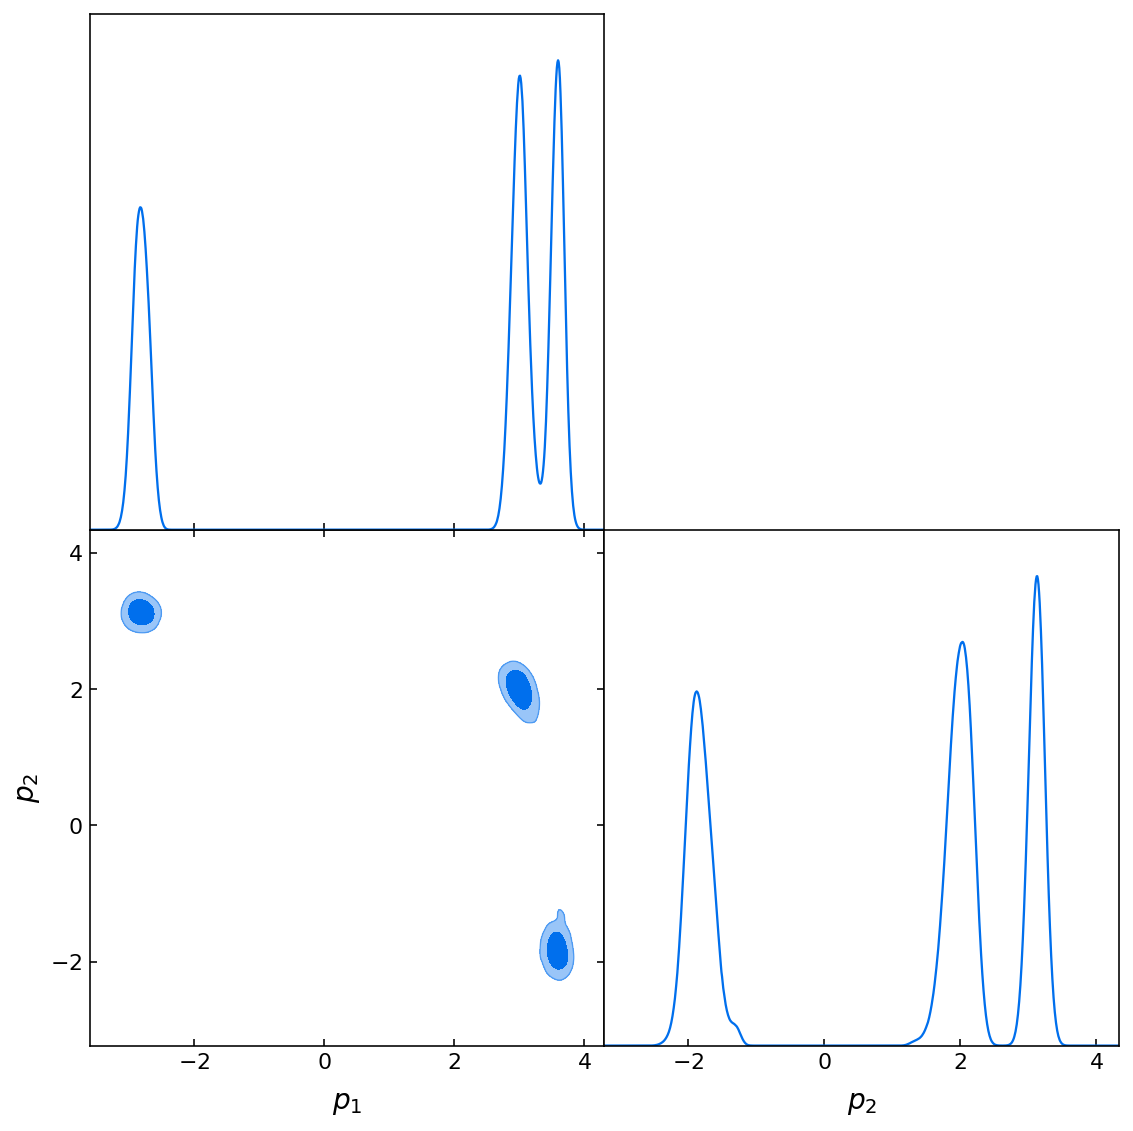

In [13]:
g = plots.getSubplotPlotter(width_inch=8)
g.triangle_plot(mc, filled=True)

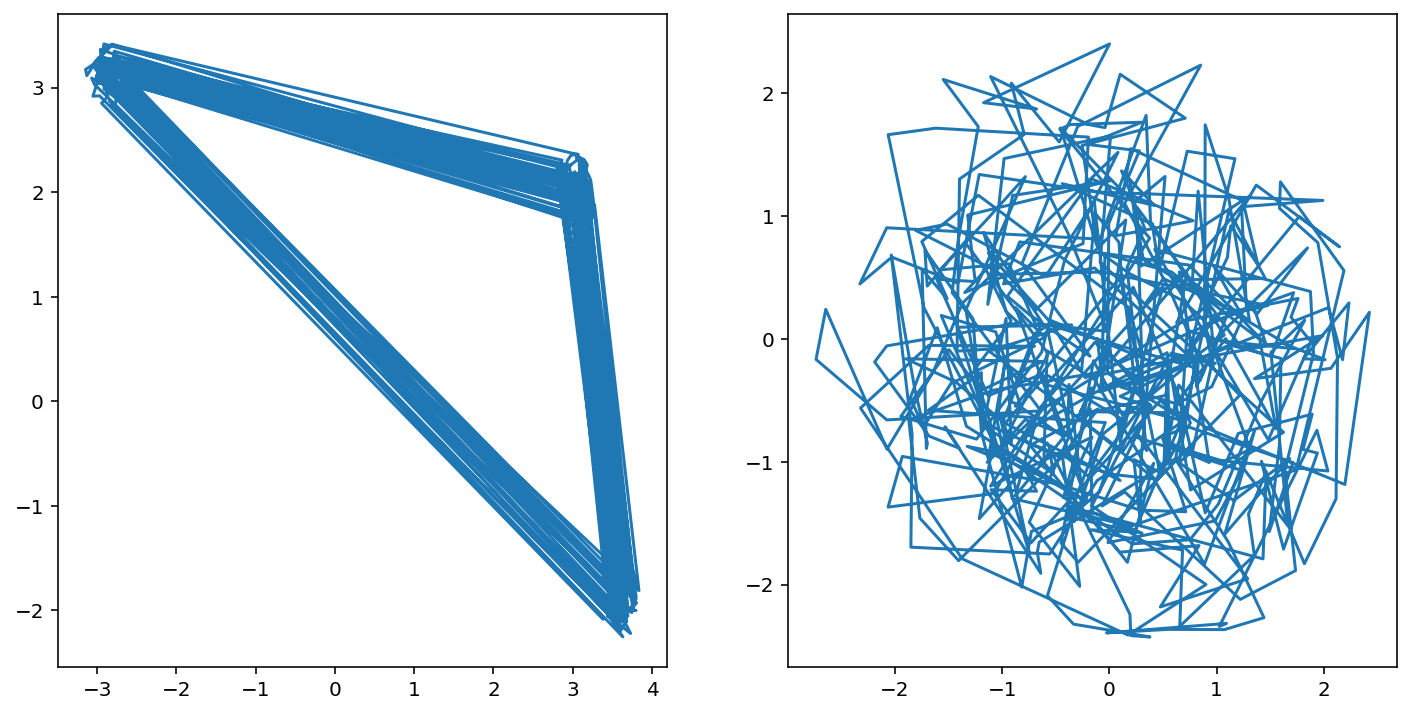

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))
ax[0].plot(samples[0][0:1000,0], samples[0][0:1000,1])
ax[1].plot(latent_samples[0][0:1000,0], latent_samples[0][0:1000,1])
plt.show()